In [2]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
from operator import add
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [3]:
sc = SparkContext("local[*]")

In [4]:
# https://udb.moe.edu.tw/Historical
# 3.學士班以下延修生數
# 9.修讀輔系人次
# 10.修讀雙主修人次

# 讀檔
raw_delay_data = sc.textFile("univ_delay.csv")
raw_minor_data = sc.textFile("univ_minor.csv")
raw_dual_data = sc.textFile("univ_dual.csv")

# 分割欄位
split_delay = raw_delay_data.map(lambda data: data.split(','))
split_minor = raw_minor_data.map(lambda data: data.split(','))
split_dual = raw_dual_data.map(lambda data: data.split(','))

In [66]:
# 只選取 學士班(日間) 的資料
def select_daytime_data(line):
    if '學士班(日間)' in line[8]:
        try: 
            int(line[4])
            return line
        except:
            pass

daytime_delay = split_delay.filter(lambda line: select_daytime_data(line))
daytime_minor = split_minor.filter(lambda line: select_daytime_data(line))
daytime_dual = split_dual.filter(lambda line: select_daytime_data(line))

In [67]:
# 把每年每間學校的人數做加總
temp_delay = daytime_delay.map(lambda row: ((row[1], row[4], row[5]), int(row[11]))).reduceByKey(add)
temp_minor = daytime_minor.map(lambda row: ((row[0], row[4], row[5]), int(row[9]))).reduceByKey(add)
temp_dual = daytime_dual.map(lambda row: ((row[0], row[4], row[5]), int(row[9]))).reduceByKey(add)

In [39]:
# 整理成 data: (學年度, 學校ID, 學校名稱, 數量) 的格式
total_delay = temp_delay.map(lambda row: (row[0][0], int(row[0][1]), row[0][2], row[1]))
total_minor = temp_minor.map(lambda row: (row[0][0], int(row[0][1]), row[0][2], row[1]))
total_dual = temp_dual.map(lambda row: (row[0][0], int(row[0][1]), row[0][2], row[1]))

total_minor.take(5)

[('101', 1, '國立政治大學', 5729),
 ('101', 2, '國立清華大學', 629),
 ('101', 3, '國立臺灣大學', 7548),
 ('101', 5, '國立成功大學', 71),
 ('101', 8, '國立中央大學', 148)]

In [54]:
# 將 RDD 轉換成 Dataframe
spark = SparkSession(sc)
rdd = sc.parallelize(total_delay.collect())
df_delay = rdd.toDF(["year", "c_id", "college", "delay"]).orderBy("year", "c_id")

rdd = sc.parallelize(total_minor.collect())
df_minor = rdd.toDF(["year", "c_id", "college", "minor"]).orderBy("year", "c_id")

rdd = sc.parallelize(total_dual.collect())
df_dual = rdd.toDF(["year", "c_id", "college", "dual"]).orderBy("year", "c_id")

# df_delay.take(5)
# df_minor.take(5)
df_dual.take(5)

[Row(year='101', c_id=1, college='國立政治大學', dual=2360),
 Row(year='101', c_id=2, college='國立清華大學', dual=141),
 Row(year='101', c_id=3, college='國立臺灣大學', dual=5339),
 Row(year='101', c_id=4, college='國立臺灣師範大學', dual=676),
 Row(year='101', c_id=5, college='國立成功大學', dual=110)]

In [55]:
# 合併所有 Dataframe
df_all = df_delay.join(df_minor, ["year", "c_id", "college"], "full").join(df_dual, ["year", "c_id", "college"], "full").orderBy("year", "c_id").toPandas()
df_all.fillna(0, inplace=True)

# Dataframe 大小
df_all.shape

(844, 6)

In [63]:
# 秀出前 5 筆資料
df_all.head(5)

,year,c_id,college,delay,minor,dual
0,101,1,國立政治大學,661.0,5729.0,2360.0
1,101,2,國立清華大學,294.0,629.0,141.0
2,101,3,國立臺灣大學,1140.0,7548.0,5339.0
3,101,4,國立臺灣師範大學,436.0,1017.0,676.0
4,101,5,國立成功大學,557.0,71.0,110.0


In [90]:
# 擷取要預測的部份及特徵
data = df_all[['delay','minor', 'dual']]
data.head(5)

,delay,minor,dual
0,661.0,5729.0,2360.0
1,294.0,629.0,141.0
2,1140.0,7548.0,5339.0
3,436.0,1017.0,676.0
4,557.0,71.0,110.0


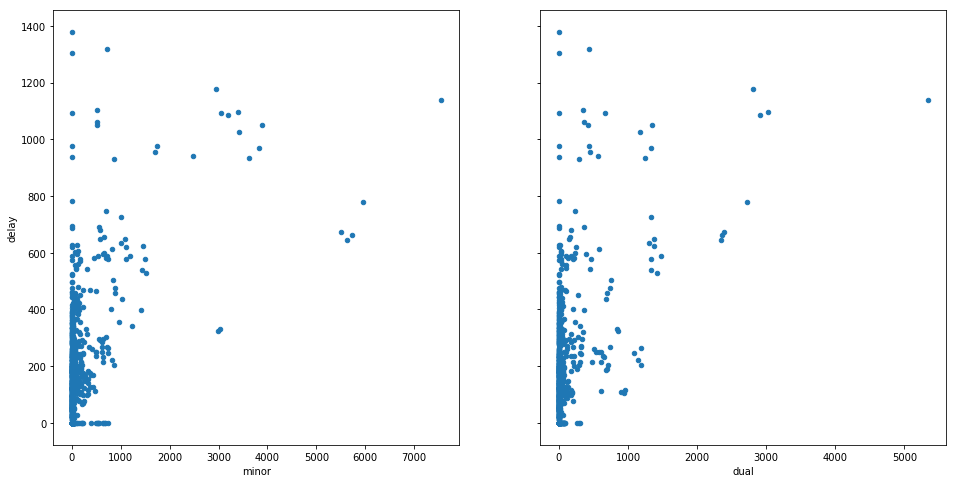

In [91]:
# 秀出資料分佈
plt.close()
fig, axs = plt.subplots(1, 2, sharey=True)
data.plot(kind='scatter', x='minor', y='delay', ax=axs[0], figsize=(16, 8))
data.plot(kind='scatter', x='dual', y='delay', ax=axs[1])
plt.show()

In [96]:
# 篩掉差距過大的個別資料
test = data.loc[data['minor'] < 2000].loc[data['dual'] < 2000]
test.shape

(828, 3)

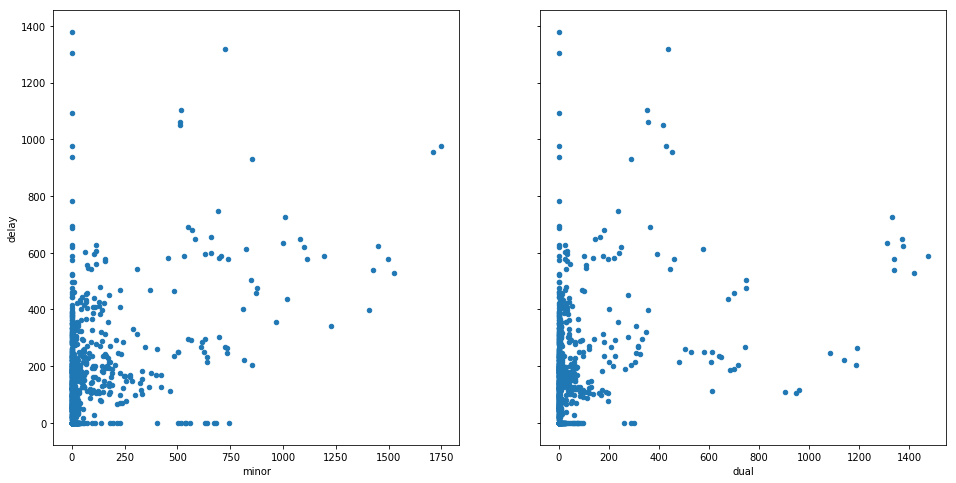

In [97]:
# 秀出篩選過的資料
plt.close()
fig, axs = plt.subplots(1, 2, sharey=True)
test.plot(kind='scatter', x='minor', y='delay', ax=axs[0], figsize=(16, 8))
test.plot(kind='scatter', x='dual', y='delay', ax=axs[1])
plt.show()

In [98]:
# 利用 LinearRegression 中的 fit() 來建立迴歸模型
feature_cols = ['minor', 'dual']
x = test[feature_cols]
y = test.delay

lm = LinearRegression()
lm.fit(x, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [99]:
# 常數項
lm.intercept_

154.4936771675039

In [100]:
# 特徵係數
lm.coef_

array([0.3396259 , 0.01761258])

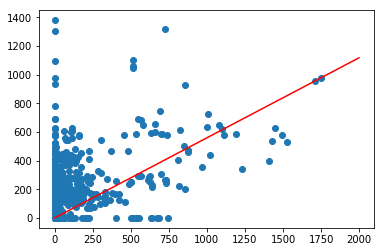

In [110]:
# 由上面的係數可以看出 delay 值受 minor 影響較大
# 因此用 minor 來觀察 delay 的走向

import numpy as np

plt.close()

# minor 的資料，delay 的資料
minor = test.minor
delay = test.delay

# (m1, d1): minor 最小點與其 delay 值
# (m2, d2): minor 最大點與其 delay 值
m1= min(minor)
m2= max(minor)
d1= min(test.loc[test['minor'] == m1]['delay'])
d2= max(test.loc[test['minor'] == m2]['delay'])

# 求算通過兩點之方程式
mrange = np.arange(0.5,2000)
line_eqn = (d2 - d1) / (m2 - m1) * (mrange - m1) + d1

# 畫出原始點
plt.scatter(minor, delay)
# 畫出線
plt.plot(line_eqn, color='red')

plt.show()


In [101]:
# 特徵值的最大與最小
x_new = pd.DataFrame({'minor': [test.minor.min(), test.minor.max()],'dual': [test.dual.min(), test.dual.max()]})
x_new.head()

,minor,dual
0,0.0,0.0
1,1747.0,1475.0


In [102]:
# 預估 delay 的最小值和最大值
preds = lm.predict(x_new)
preds

array([154.49367717, 773.79868182])